<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/LeakyRegularized_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.losses import Huber

## Data Prep

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/RegresiUTSTelkom.csv', low_memory=False)
df.shape

(515344, 91)

In [ ]:
df.describe()

,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
count,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,...,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000
mean,1998.397077,43.387113,1.289515,8.658222,1.164110,-6.553580,-9.521968,-2.391046,-1.793215,3.727868,...,15.755411,-73.461537,41.542388,37.934163,0.315750,17.669292,-26.315520,4.458653,20.035229,1.329104
std,10.931056,6.067557,51.580393,35.268505,16.322802,22.860803,12.857763,14.571853,7.963822,10.582869,...,32.099666,175.619058,122.228915,95.050718,16.161780,114.428002,173.977455,13.346567,185.558415,22.088598
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954667,-26.059848,-11.462775,-8.487507,-20.666455,-18.441005,-10.780360,-6.468390,-2.293670,...,-1.812658,-139.555737,-20.987115,-4.669655,-6.781598,-31.580617,-101.530305,-2.566137,-59.509453,-8.820248
50%,2002.000000,44.258490,8.417725,10.476235,-0.652855,-6.007770,-11.188355,-2.046625,-1.736415,3.822305,...,9.171850,-53.089115,28.790580,33.623815,0.820830,15.598520,-21.204225,3.117645,7.759910,0.053015
75%,2006.000000,47.833875,36.124030,29.764685,8.787548,7.741877,-2.388945,6.508587,2.913455,9.961865,...,26.274487,13.478793,89.661785,77.785810,8.471000,67.795110,52.389322,9.967742,86.351645,9.679540
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [ ]:
df.isnull().sum()

,0
2001,0
49.94357,0
21.47114,0
73.0775,0
8.74861,0
...,...
-23.08793,0
68.40795,0
-1.82223,0
-27.46348,0


## Preprocessing

In [ ]:
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [ ]:
X = df_imputed.iloc[:, 1:]  # Fitur
y = df_imputed.iloc[:, 0]   # Target
df_combined = pd.concat([y, X], axis=1)

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [ ]:
df_clean = remove_outliers_iqr(df_combined, df_combined.columns[0])

In [ ]:
corr = df_clean.corr()
target_corr = corr.iloc[1:, 0].abs()
threshold = 0.1
selected_features = target_corr[target_corr > threshold].index.tolist()

In [ ]:
if not selected_features:
    threshold = target_corr.max() * 0.5
    selected_features = target_corr[target_corr > threshold].index.tolist()

In [ ]:
X_filtered = df_clean[selected_features]
y_filtered = df_clean.iloc[:, 0]

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

In [ ]:
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_filtered.values.reshape(-1, 1)).flatten()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## Modeling

In [ ]:
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64,callbacks=[early_stop], verbose=1)

Epoch 1/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - loss: 0.5548 - mae: 0.7462 - val_loss: 0.3490 - val_mae: 0.6852
Epoch 2/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step - loss: 0.3499 - mae: 0.6894 - val_loss: 0.3422 - val_mae: 0.6850
Epoch 3/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 75s 11ms/step - loss: 0.3462 - mae: 0.6888 - val_loss: 0.3430 - val_mae: 0.6878
Epoch 4/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 0.3454 - mae: 0.6879 - val_loss: 0.3414 - val_mae: 0.6852
Epoch 5/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - loss: 0.3453 - mae: 0.6880 - val_loss: 0.3422 - val_mae: 0.6869
Epoch 6/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 74s 8ms/step - loss: 0.3451 - mae: 0.6879 - val_loss: 0.3426 - val_mae: 0.6870
Epoch 7/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 0.3447 - mae: 0.6876 - val_loss: 0.3414 - val_mae: 0.6876
Epoch 8/50
4857/4857 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.3443 - mae: 0.6875 - val_loss: 0.3412 - val_mae: 0.6857
Epoch 9/50
4857/4857 ━━━━━━━

In [ ]:
y_pred_scaled = model.predict(X_test).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Hitung metrik evaluasi
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

3036/3036 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MSE: 49.871793906590064
RMSE: 7.061996453311915
MAE: 5.320946241596228
R-squared: 0.1734083439576759


## Visualize

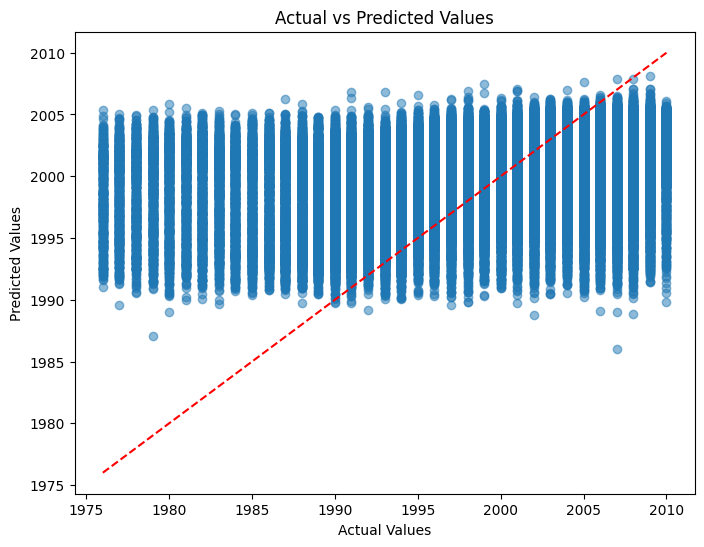

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


## 1. Persiapan Data dan Eksplorasi Awal
* **Pemeriksaan Data Awal**:
  - Mengecek dimensi data dengan `df.shape`
  - Melihat statistik deskriptif dengan `df.describe()`
  - Memeriksa missing values dengan `df.isnull().sum()`

## 2. Preprocessing Data

* **Penanganan Missing Values**:
  - Menggunakan `SimpleImputer` dengan strategi median untuk mengisi nilai yang hilang
  - Rumus imputasi median:  
  $$\text{median} = Q_2 = \text{nilai tengah setelah diurutkan}$$

* **Pemisahan Fitur dan Target**:
  - Kolom pertama dijadikan target (y)
  - Kolom lainnya dijadikan fitur (X)

* **Penanganan Outlier**:
  - Menggunakan metode IQR (Interquartile Range) untuk mengidentifikasi dan menghapus outlier
  - Rumus IQR:  
  $$\text{IQR} = Q_3 - Q_1$$  
  $$\text{Batas bawah} = Q_1 - 1.5 \times \text{IQR}$$  
  $$\text{Batas atas} = Q_3 + 1.5 \times \text{IQR}$$

* **Seleksi Fitur**:
  - Memilih fitur berdasarkan korelasi dengan target
  - Ambang batas korelasi absolut > 0.1
  - Jika tidak ada fitur yang memenuhi, ambang batas diturunkan menjadi 50% dari korelasi maksimum

## 3. Normalisasi Data

* **Standarisasi Fitur**:
  - Menggunakan `StandardScaler` untuk menstandarisasi fitur
  - Rumus standarisasi:  
  $$x_{\text{std}} = \frac{x - \mu}{\sigma}$$

* **Normalisasi Target**:
  - Juga menggunakan `StandardScaler` untuk target
  - Dilakukan invers transform setelah prediksi untuk mendapatkan nilai asli

## 4. Pembagian Data

* **Train-Test Split**:
  - Membagi data menjadi 80% training dan 20% testing
  - Menggunakan `random_state=42` untuk reproduktibilitas

## 5. Pembangunan Model Neural Network

* **Arsitektur Model**:
  - Model Sequential dengan 3 hidden layer (256, 128, 64 neuron)
  - Menggunakan L2 regularization dengan λ=0.001
  - Batch Normalization setelah setiap dense layer
  - Aktivasi LeakyReLU untuk non-linearitas
  - Dropout rate 0.2 untuk pencegahan overfitting

* **Konfigurasi Training**:
  - Optimizer: Nadam dengan learning rate 0.0005
  - Loss function: Huber loss (lebih robust terhadap outlier daripada MSE)
  - Metrik evaluasi: MAE (Mean Absolute Error)
  - Callbacks:
    - EarlyStopping dengan patience=5
    - ReduceLROnPlateau untuk penyesuaian learning rate otomatis

## 6. Pelatihan Model

* **Proses Training**:
  - Epochs: 50 (dengan early stopping)
  - Batch size: 64
  - Validation split: 20% dari data training
  - Menggunakan `verbose=1` untuk menampilkan progress

## 7. Evaluasi Model

* **Transformasi Kembali Prediksi**:
  - Menginvers transformasi scaling pada prediksi dan nilai test aktual

* **Metrik Evaluasi**:
  - **Mean Squared Error (MSE)**:  
  $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$  

  - **Root Mean Squared Error (RMSE)**:  
  $$\text{RMSE} = \sqrt{\text{MSE}}$$  

  - **Mean Absolute Error (MAE)**:  
  $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$  

  - **R-squared (R²)**:  
  $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

## 8. Visualisasi Hasil

* **Actual vs Predicted Plot**:
  - Scatter plot nilai aktual vs prediksi
  - Garis diagonal merah menunjukkan prediksi sempurna
  - Visualisasi membantu mengevaluasi sebaran dan pola prediksi